# Assignment 7: Bagging and Boosting

Only use the already imported library `numpy`, `matplotlib` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`). Make sure that the dataset `titanic.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

<h3>

Min Wang 3440557

Sisi Miao 3377882
    
Dominik Sellenthin 2836308   
    
</h3>

We are Master students.


In [4]:
# You are allowed to use the numpy package and the DecisionTreeClassifier.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier


def load_dataset(path):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_csv('titanic.csv')
    # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
    # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
    df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # We map the Title attribute to a one-hot encoding.
    df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

    # We map the Sex attribute to a numeric representation.
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    # We one-hot encode Pclass.
    df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

    # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
    # we can determine whether a passenger was on board alone.
    df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

    # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
    df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

    # For remaining features, we have to separate train and test, 
    # as we will impute missing data based on statistics in the training data.
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
    # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
    def impute_embarked():    
        freq_port = df_train['Embarked'].dropna().mode()[0]
        output = []
        for df in (df_train, df_test):
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
            df = df.drop('Embarked', axis=1)
            output.append(df)
        return output

    df_train, df_test = impute_embarked()

    # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
    guess_ages = np.zeros((2, 3))
    for df in (df_train, df_test):
        for i in range(2):
            for j in range(3):
                guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
        for i in range(2):
            for j in range(3):
                df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
        df['Age'] = df['Age'].astype(int)

    df_train = df_train.drop(['Pclass'], axis=1)
    df_test = df_test.drop(['Pclass'], axis=1)

    X_train = df_train.values[:, 1:]
    X_test = df_test.values[:, 1:]
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset('titanic.csv')



#print(X_train.shape)
#print(X_train[0,:])

(712, 15)
[ 0.   20.    7.05  0.    0.    1.    0.    0.    0.    0.    1.    1.
  0.    0.    1.  ]


In [182]:
#print(X_train.shape[0])
#print(y_train)

712


The Titanic dataset and a description can be found at [Kaggle](https://www.kaggle.com/c/titanic/data). The feature engineering mostly follows the work by [Manav Segal](https://www.kaggle.com/startupsci/titanic-data-science-solutions). 

The prepared dataset contains the following attributes:
- Sex: binary (0 = Male, 1 = Female)
- Age: integer
- Fare: float
- Title_{Master, Miss, Mr, Mrs, Rare}: title of passenger (extracted from name), binary, one-hot encoding of categorical variable Title
- Pclass_{1, 2, 3}: ticket class corresponds to socio-economic status (1 = upper class, 2 = middle class, 3 = lower class), binary, one-hot encoding of categorical variable Pclass
- IsAlone: whether the passenger has no siblings/spouses/parents/children on board, binary
- Embarked_{C, Q, S}: port at which passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton), binary, one-hot encoding of categorical variable Embarked

The classification target is:
- Survived: binary

Data is split into train-test with a 80-20 ratio yielding 712 training and 179 test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Task 1: Random Forest

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be weighted equally in the majority vote. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose. 


In [166]:
class RandomForestClassifier(object):
    def __init__(self, X,y, number_of_trees, max_features, max_samples=0.2, depth=None, min_samples_leaf=2):
        # Add your code, such as initialization of trees here.
        np.random.seed(12)
        self.X, self.y=X,y
        
        self.max_features = max_features

        self.number_of_trees = number_of_trees
        self.max_samples, self.depth, self.min_samples_leaf  = max_samples, depth, min_samples_leaf
        
        self.trees = [self.create_tree() for i in range(self.number_of_trees)]
        
    def create_tree(self):
        # Implement your training here.
 
 
        return DecisionTreeClassifier(max_features=self.max_features,max_depth = self.depth, min_samples_leaf=self.min_samples_leaf)
    
    def fit (self, X, y):
        self.max_samples=int(X_train.shape[0]*0.2)
        idxs = np.random.permutation(len(self.y))[:self.max_samples]
        return [t.fit(X[idxs], y[idxs]) for t in self.trees]
    
    def predict(self, X):
        # Implement your prediction here.
        '''for t in self.trees:
            pridiction=t.predict(X) 
            print('pridiction',pridiction)
        '''
        pred=np.mean([t.predict(X) for t in self.trees], axis=0)
        pred=np.where(pred > 0.5,1,0)
        #print('pred',pred)
        #print('pred, after',pred)
        return pred



In [167]:
# Implement your training and evaluation here.

rf = RandomForestClassifier(X_train,y_train, number_of_trees=10,max_features=6)
# Train the model on training data
rf.fit(X_train, y_train)

# Use the forest's predict method on the test data
y_pred = rf.predict(X_test)


#evaluate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
#print('y_test',y_test, 'y_pred',y_pred)
print('confusion_matrix',confusion_matrix(y_test, y_pred))
print('precision_recall_fscore_support',precision_recall_fscore_support(y_test, y_pred, average='macro'))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('roc_auc',roc_auc)


confusion_matrix [[99  6]
 [35 39]]
precision_recall_fscore_support (0.8027363184079602, 0.7349420849420849, 0.7419570338595689, None)
roc_auc 0.7349420849420849


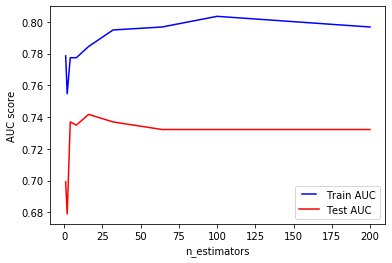

In [168]:

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(X_train,y_train,max_features=6,number_of_trees=estimator)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

We can see that for our data and fix other parameters, we can stop at 16 trees for test data as increasing the number of trees decreases the test performance. 


## Task 2: Interpreting Random Forests

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyse learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

In [169]:
def create_forest():
    import sklearn.ensemble
    import sklearn.metrics
    forest = sklearn.ensemble.RandomForestClassifier(8)
    forest.fit(X_train, y_train)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_test, forest.predict(X_test))
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    return forest

forest = create_forest()

Precision: [0.78070175 0.75384615]
Recall: [0.84761905 0.66216216]
F1-score: [0.81278539 0.70503597]


In [179]:
# Implement your solution here.


from sklearn.metrics import accuracy_score

from collections import defaultdict

names=['Sex','Age','Fare',
'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
'Pclass_1', 'Pclass_2', 'Pclass_3',
'IsAlone','Embarked_C', 'Embarked_Q', 'Embarked_S']

acc = accuracy_score(y_test, forest.predict(X_test))
print('Original accuracy :',acc)
scores = defaultdict(list)
for i in range(X_train.shape[1]):
    X_t = X_test.copy()
    np.random.shuffle(X_t[:, i])
    shuff_acc = accuracy_score(y_test, forest.predict(X_t))
    scores[names[i]].append(acc-shuff_acc)
print ("Features sorted by their score:")
print (sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Original accuracy : 0.770949720670391
Features sorted by their score:
[(0.1173, 'Title_Mr'), (0.0782, 'Sex'), (0.0335, 'Pclass_3'), (0.0279, 'Title_Miss'), (0.0223, 'Embarked_Q'), (0.0168, 'Title_Master'), (0.0168, 'Pclass_2'), (0.0168, 'Age'), (0.0112, 'Fare'), (0.0112, 'Embarked_S'), (0.0, 'Title_Rare'), (0.0, 'Title_Mrs'), (0.0, 'Embarked_C'), (-0.0056, 'Pclass_1'), (-0.0279, 'IsAlone')]


We add the namesList for features (We assume the list is correct.)
After Permuting, the accuracy Decreacy scores are showed as above.
We noticed that 'Title_Mr', 'Sex', 'Pclass_3','Title_Miss' are more important than other features. 
A negative value in the importance means that the random permutation of a feature worked better than the original values. This implies that the feature has no role in the prediction and is therefore not important.

## Task 3: Discrete AdaBoost with Decision Stumps
 
*For all students other than B.Sc. Data Science.*  

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [229]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


class AdaBoostClassifier(object):
    def __init__(self, n_learners=50):
        self.n_learners = n_learners
        # Add any initialization you need here.
       
        
        
    
    def fit(self, X, y):
        # Implement your solution here.
        weights = np.full(y.shape,1/len(y)) # init weights for all samples in dataset-> w = 1/N


        # for storing stumps
        self.clfs=[]
        
        
        for _ in range(self.n_learners):#build up desicion stumps
            min_error=float('inf')
            clf = initialize_decision_stump() 
                
            clf = clf.fit(X,y,sample_weight=weights) 
            # Append the single weak classifiers to a list which is later on used to make the weighted decision

            predictions = clf.predict(X)

            
            # Calculate the weighted misclassification rate 
            wrong_flag=np.where(y!=predictions,1,0)
            err = np.sum(weights*wrong_flag)/np.sum(weights)


            # Calculate the alpha value(amount of say) for a stump
            clf.alpha = 0.5*np.log((1-err)/err+1e-10) #in case of error=0

            
            # Update the weights wi --> These updated weights are used in the sample_weight parameter for the training of the next decision stump. 
            weights *= np.exp(-clf.alpha*y*predictions)#1 if y=pred; -1 if y!=pred
            weights /= np.sum(weights)#normaliaztion 

            self.clfs.append(clf)
        
        
    
    def predict(self, X, y):
        # Implement your solution here.
        
        # With each model in the model list, make a prediction 
        clf_preds=[clf.alpha*clf.predict(X) for clf in self.clfs]#Individual weighted prediction for all models (shape:n_learners*numberOfsamples)
    
        y_pred=np.sign(np.sum(clf_preds,axis=0))#overall prediction for all samples(shape:1*numberOfsamples)
        
        return y_pred


In [230]:
# Implement your training and evaluation here. You may reuse the code from Task 1.
#class1 -> +1, class 2 -> -1
y_train_modified=np.where(y_train==0,-1,1)
y_test_modified=np.where(y_test==0,-1,1)

#training
classifier = AdaBoostClassifier(n_learners=50)
classifier.fit(X_train, y_train_modified)
y_pred = classifier.predict(X_test,y_test_modified)


#evaluate
print('y_test_modified',y_test_modified, 'y_pred',y_pred)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_modified, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('roc_auc',roc_auc)



y_test_modified [ 1 -1  1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1
 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1  1  1  1 -1 -1
  1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1
  1 -1  1 -1 -1  1  1 -1 -1 -1  1] y_pred [ 1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.
 -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1.
  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.
  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.
 -1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  

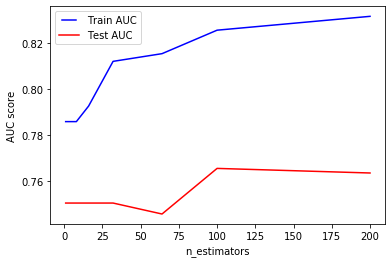

In [232]:
#evaluation
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    classifier = AdaBoostClassifier(n_learners=estimator)
    classifier.fit(X_train, y_train_modified)
    
    y_pred = classifier.predict(X_test,y_test_modified)
    train_pred = classifier.predict(X_train,y_test_modified)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_modified, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_modified, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

When we increase the number of weak learners the auc score increases for traning data; while for the test data, the curve is a little bit strange and we don't know how to explain it and hope we can get some tutoring about it.